# Hybrid text-and-metadata model

This notebook blends the strongest baseline from **`baseline_text_models.ipynb`**  
(title TF-IDF + Logistic Regression) with the engineered metadata columns that
were used in **`etenders.ipynb`**.

* 5-fold stratified cross-validation for a fair comparison  
* Calibrated probabilities so every model exposes `predict_proba`  
* Automatic threshold search to hit a configurable recall target

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV

# project helper
from prepare_data import load_clean_dataframe  # type: ignore


def threshold_for_recall(scores, y_true, recall_target=0.85):
    """Return the highest threshold that still achieves recall ≥ target."""
    prec, rec, thr = precision_recall_curve(y_true, scores)
    candidates = [t for r, t in zip(rec[:-1], thr) if r >= recall_target]
    return max(candidates) if candidates else thr.min()

In [2]:
df = load_clean_dataframe(labelled_only=True)

# Minimal examples of the extra features from *etenders.ipynb*
df["title_len"] = df["title"].str.len()
df["contains_date"] = df["title"].str.contains(r"\b20\d{2}\b", regex=True).astype(int)
# ➜ add more flags / numeric columns here to match the full notebook

df["has_pdf"] = df["pdf_url"].notna() & df["pdf_url"].str.strip().ne("")
df["has_pdf"] = df["has_pdf"].astype(int)

text_col = "title"
cat_cols = ["ca", "procedure"]
num_cols = ["has_pdf"]

y = df["bid"].astype(int).values
X = df.drop(columns=["bid"])

/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ca"].fillna("", inplace=True)
/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

In [8]:
preprocess = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),
                min_df=3,
                max_features=40_000,
                strip_accents="unicode",
                lowercase=True,
            ),
            text_col,
        ),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

base_clf = LogisticRegression(
    max_iter=400,
    class_weight="balanced",
    solver="lbfgs",
    n_jobs=-1,
)

pipe = Pipeline([("prep", preprocess), ("clf", base_clf)])
calibrated = CalibratedClassifierCV(pipe, cv=3, method="sigmoid")

Chosen threshold to hit recall ≥0.85  →  0.049
              precision    recall  f1-score   support

           0      0.985     0.695     0.815      1955
           1      0.166     0.856     0.278       139

    accuracy                          0.705      2094
   macro avg      0.576     0.775     0.547      2094
weighted avg      0.931     0.705     0.779      2094



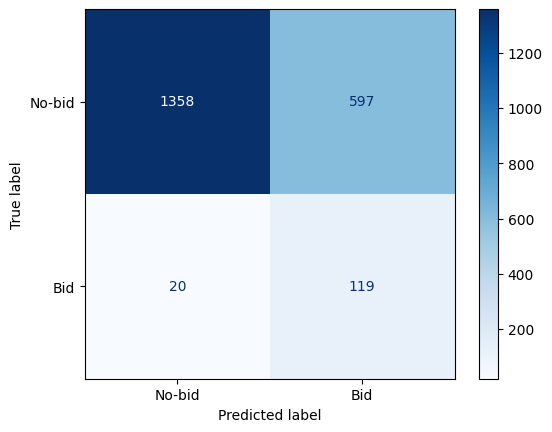

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

proba = cross_val_predict(
    calibrated, X, y, cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

thr = threshold_for_recall(proba, y, recall_target=0.85)
print(f"Chosen threshold to hit recall ≥0.85  →  {thr:.3f}")

y_pred = (proba >= thr).astype(int)

print(classification_report(y, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(
    y, y_pred, display_labels=["No-bid", "Bid"], cmap="Blues"
)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

calibrated.fit(X_train, y_train)          # 1️⃣ train once
proba = calibrated.predict_proba(X_test)[:, 1]   # 2️⃣ scores for *test* only

threshold = 0.046
recall = 0.9285714285714286


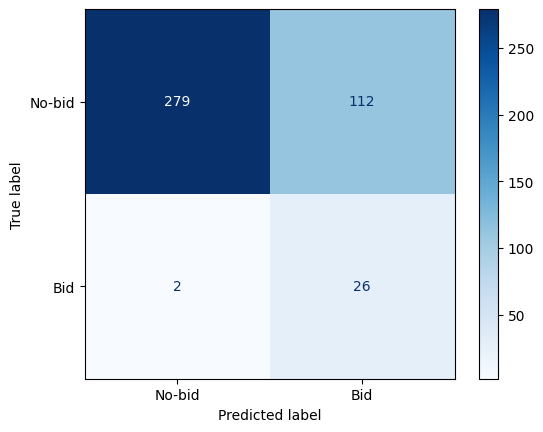

In [16]:
from sklearn.metrics import recall_score, ConfusionMatrixDisplay

# choose the highest threshold that still reaches the recall you need
thr = threshold_for_recall(proba, y_test, recall_target=0.90)   # ← e.g. 90 % recall
print(f"threshold = {thr:0.3f}")

y_pred = (proba >= thr).astype(int)

print("recall =", recall_score(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=["No-bid", "Bid"],
                                        cmap="Blues")